# Import Required Libraries

In [42]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

## Import Image

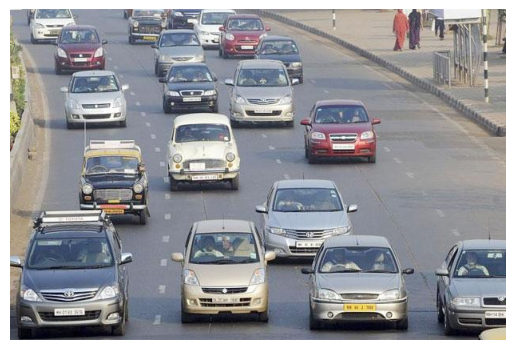

In [2]:
cars = cv2.imread("images/cars.jpg")

plt.imshow(cars[:,:,::-1]);
plt.axis("off");

# Load Models

In [7]:
model_v8   = YOLO('models/yolov8n.pt')
east_model = cv2.dnn.readNet("models/frozen_east_text_detection.pb")

In [9]:
### Layer names that we are interested in from EAST model

layernames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

In [11]:
def plot_img(img):
    plt.axis('off');
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    plt.show();

## Detect Vehicles

In [75]:
def get_bounding_boxes(image):
    ### Predict Classes from image
    predict_image = model_v8(image)
    
    print(image.shape)
    
    ### Filter only cars
    predict_image[0].boxes.data = torch.stack([box for box in predict_image[0].boxes.data if (int(box[5]) == 2) and (box[4] > 0.5)])
    boxes = predict_image[0].boxes.data
    
    ### Plot
    res_plot = predict_image[0].plot()
    plot_img(res_plot)
    


0: 448x640 4 persons, 17 cars, 1 bus, 195.0ms
Speed: 6.0ms preprocess, 195.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


(414, 621, 3)


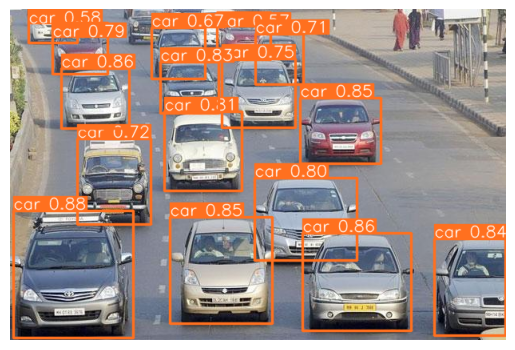

tensor([[4.7516e+00, 2.5297e+02, 1.5437e+02, 4.1136e+02, 8.8361e-01, 2.0000e+00],
        [3.6666e+02, 2.8054e+02, 5.0238e+02, 4.0205e+02, 8.6395e-01, 2.0000e+00],
        [6.4304e+01, 7.4432e+01, 1.4912e+02, 1.4998e+02, 8.5662e-01, 2.0000e+00],
        [3.6302e+02, 1.1151e+02, 4.6441e+02, 1.9382e+02, 8.5475e-01, 2.0000e+00],
        [2.0001e+02, 2.6076e+02, 3.2827e+02, 3.9331e+02, 8.5111e-01, 2.0000e+00],
        [5.3116e+02, 2.8705e+02, 6.2066e+02, 4.0851e+02, 8.4172e-01, 2.0000e+00],
        [1.8900e+02, 6.6465e+01, 2.6125e+02, 1.3080e+02, 8.2637e-01, 2.0000e+00],
        [1.9373e+02, 1.2826e+02, 2.9007e+02, 2.2742e+02, 8.0743e-01, 2.0000e+00],
        [3.0621e+02, 2.1178e+02, 4.3407e+02, 3.1432e+02, 7.9708e-01, 2.0000e+00],
        [5.3704e+01, 1.7076e+01, 1.2272e+02, 8.1278e+01, 7.8819e-01, 2.0000e+00],
        [2.6563e+02, 6.2075e+01, 3.5715e+02, 1.4812e+02, 7.5247e-01, 2.0000e+00],
        [8.4331e+01, 1.6258e+02, 1.7679e+02, 2.6916e+02, 7.1598e-01, 2.0000e+00],
        [3.0708e

In [76]:
get_bounding_boxes(cars)

## Detect Texts from bouding boxes

In [ ]:
def detect_text_from_image()